# Experiments with Synthetic Data

This notebook shows how to reproduce the experiments in *Approximate Inference for Constructing Astronomical Catalogs from Images* using the [Celeste.jl](https://github.com/jeff-regier/Celeste.jl) package and Julia 0.6.4. To install Celeste, run
```
Pkg.update()
Pkg.add("Celeste")
```

In [1]:
# Pkg.status("Celeste")

In [2]:
import Celeste: AccuracyBenchmark, SDSSIO, Synthetic, ParallelRun
using DataFrames

## 1. Visually check that synthetic data resembles real data

In [3]:
coadd_catalog = AccuracyBenchmark.load_coadd_catalog(AccuracyBenchmark.COADD_CATALOG_FITS)

# filter the coadd catalog -- these columns can't be missing
no_na_cols = :flux_r_nmgy, :color_ug, :color_gr, :color_ri, :color_iz
for col in no_na_cols
    coadd_catalog = coadd_catalog[.!ismissing.(coadd_catalog[col]), :]
end

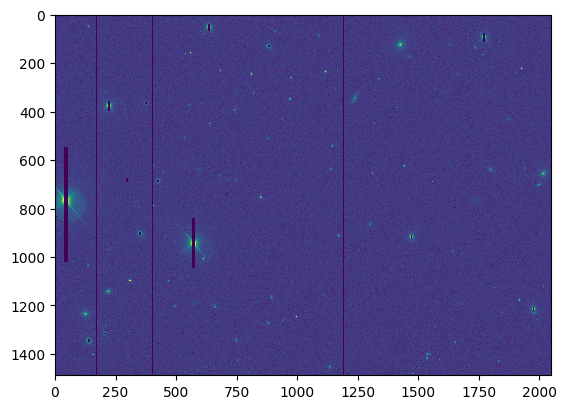

In [4]:
# load SDSS images
dataset = SDSSIO.SDSSDataSet(AccuracyBenchmark.SDSS_DATA_DIR)
sdss_images = SDSSIO.load_field_images(dataset, AccuracyBenchmark.STRIPE82_RCF);
AccuracyBenchmark.plot_image(sdss_images[3]);

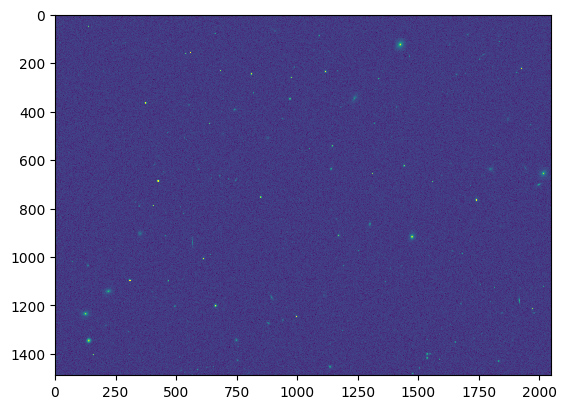

In [5]:
# generate images by conditioning on the coadd catalog
conditional_images = deepcopy(sdss_images)
catalog_entries = [
    AccuracyBenchmark.make_catalog_entry(row)
        for row in eachrow(coadd_catalog)]
Synthetic.gen_images!(conditional_images, catalog_entries)
AccuracyBenchmark.plot_image(conditional_images[3]);

## 2. Draw a catalog from the prior

In [6]:
prior_catalog = AccuracyBenchmark.generate_catalog_from_celeste_prior(500, 12345)
head(prior_catalog)

,ra,dec,is_star,flux_r_nmgy,color_ug,color_gr,color_ri,color_iz,gal_frac_dev,gal_axis_ratio,gal_radius_px,gal_angle_deg
1,0.535903,0.627301,false,7.5945,-0.172541,1.09821,0.643075,-0.381725,0.272905,0.096291,1.84125,166.017
2,0.544344,0.550995,false,0.989773,-4.28371,1.37187,0.496161,1.30101,0.720652,0.655117,6.1787,50.211
3,0.455679,0.442466,true,8.91759,3.31271,1.22492,0.358178,0.269155,missing,missing,missing,missing
4,0.469984,0.473291,false,4.05966,0.597365,-0.00497866,0.288615,0.598756,0.386987,0.463955,10.2972,87.5557
5,0.492634,0.452557,true,5.92552,0.72135,2.00172,1.53289,1.0992,missing,missing,missing,missing
6,0.524173,0.563189,false,0.217006,-1.08506,1.64567,0.811115,-0.0872554,0.209362,0.503684,7.22285,97.8714


## 3. Draw an image sets for the catalog

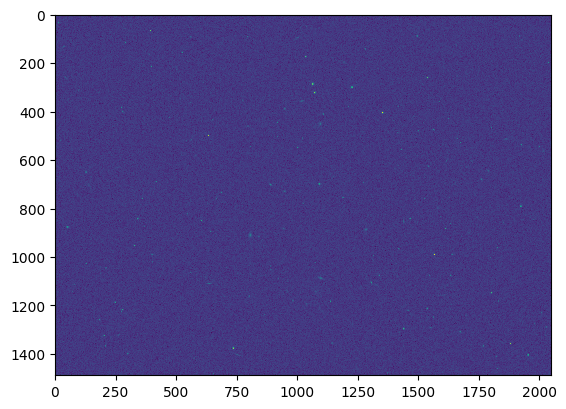

In [7]:
# generate images based on the prior catalog
prior_images = deepcopy(sdss_images)
catalog_entries = [
    AccuracyBenchmark.make_catalog_entry(row)
        for row in eachrow(prior_catalog)]
Synthetic.gen_images!(prior_images, catalog_entries)
AccuracyBenchmark.plot_image(prior_images[3]);

## 4. Run variational inference (VI) on the image set

The next block of code takes about 30 minutes single threaded. To enable more threads, before launching Jupyter, set two environment variables:
```
export OMP_NUM_THREADS=1
export JULIA_NUM_THREADS=4
```

In [8]:
init_catalog = AccuracyBenchmark.make_initialization_catalog(prior_catalog, false);
box = ParallelRun.BoundingBox(-1000.0, 1000.0, -1000.0, 1000.0)
# method can be either :single_vi or :joint_vi
vi_results = ParallelRun.infer_box(sdss_images, box; catalog = init_catalog, method = :single_vi);
celeste_catalog = AccuracyBenchmark.celeste_to_df(vi_results)

[1]<1> INFO: processing box -1000.0, 1000.0, -1000.0, 1000.0 with 4 threads
[1]<1> INFO: #1 at (0.5360125981954499, 0.6272462860811433): 61.230819484 secs
[1]<4> INFO: #2 at (0.5444544489601483, 0.5509396421203607): 61.558670722 secs
[1]<3> INFO: #3 at (0.45578914819184124, 0.44241090429301827): 64.284493634 secs
[1]<2> INFO: #4 at (0.4700939867317873, 0.47323606691731035): 66.241625958 secs
[1]<1> INFO: #5 at (0.4927437525625394, 0.45250190580262983): 13.337339632 secs
[1]<3> INFO: #7 at (0.5100697778129417, 0.44613082085901956): 11.376138014 secs
[1]<4> INFO: #6 at (0.5242830004841185, 0.5631338455745681): 14.226171256 secs
[1]<2> INFO: #8 at (0.5581921564098355, 0.5419435129808391): 21.282483718 secs
[1]<1> INFO: #9 at (0.45042084155297424, 0.45368215431073994): 14.856562896 secs
[1]<4> INFO: #11 at (0.4609478289496565, 0.4815392714297357): 14.577984937 secs
[1]<3> INFO: #10 at (0.5944083671555331, 0.522986283666032): 17.883514642 secs
[1]<2> INFO: #12 at (0.48029845272632515, 0.475

,ra,dec,is_star,gal_frac_dev,gal_axis_ratio,gal_radius_px,gal_angle_deg,flux_r_nmgy,color_ug,color_gr,color_ri,color_iz,log_flux_r_stderr,color_ug_stderr,color_gr_stderr,color_ri_stderr,color_iz_stderr
1,0.536113,0.627146,0.00590743,0.0104276,0.989566,2.18575,117.27,0.368052,0.247231,1.04478,0.295552,0.381443,0.273056,0.806234,0.326958,0.202198,0.341023
2,0.544355,0.55104,0.00547051,0.0117879,0.988112,2.40784,124.378,0.36859,0.974934,0.848564,0.386676,0.345838,0.302239,0.892049,0.352292,0.199966,0.298168
3,0.455693,0.442311,0.00501182,0.0100411,0.0108806,0.0899043,178.338,9.12377,2.85011,1.13517,0.561463,0.294403,0.0111705,0.555898,0.0370039,0.0151874,0.0371922
4,0.470117,0.473136,0.241746,0.988329,0.988602,1.65057,32.7305,0.36803,1.19955,0.812323,0.204068,0.203049,0.25341,0.858784,0.32297,0.189895,0.288691
5,0.492844,0.452602,0.00555095,0.0109461,0.989668,2.21929,102.597,0.368284,0.265009,0.813849,0.295012,0.309509,0.289345,0.820698,0.331731,0.195373,0.299202
6,0.510169,0.446231,0.00538421,0.0122378,0.988252,3.27534,116.786,0.84682,-0.777914,0.51514,0.296509,0.284022,0.178329,0.334345,0.226177,0.196316,0.312295
7,0.524183,0.563034,0.00535991,0.0108651,0.989542,2.51233,172.464,0.367985,0.123539,0.907313,0.26586,0.333238,0.260523,0.802764,0.328897,0.197316,0.307226
8,0.558092,0.541844,0.00500461,0.0100067,0.0100044,2.38638,55.5836,18.9724,1.84053,0.379815,0.545803,0.18652,0.0173237,0.257813,0.0311154,0.0268144,0.0726155
9,0.450501,0.453582,0.0942526,0.988608,0.0124331,0.18694,55.044,0.36797,1.24251,0.768394,0.28966,0.300244,0.208226,0.815646,0.306142,0.1819,0.284688
10,0.46087,0.481639,0.00598698,0.0113719,0.98936,2.15499,37.5227,0.369426,0.637131,0.809714,0.312645,0.325693,0.298469,0.83222,0.335058,0.194219,0.297734


## 5. Run MCMC on the image set

TODO

## 6. Score predictions

In [9]:
prediction_dfs = [celeste_catalog,]
scores = AccuracyBenchmark.score_predictions(prior_catalog, prediction_dfs)

,N,first,field
1,22,0.954545,missed_stars
2,67,0.0597015,missed_galaxies
3,89,0.474664,position
4,89,2.21589,flux_r_mag
5,89,9.48857,flux_r_nmgy
6,6,48.8524,gal_angle_deg
7,15,0.461694,gal_frac_dev
8,15,0.344998,gal_axis_ratio
9,15,2.57081,gal_radius_px
10,89,1.7546,color_ug


## 7. Score uncertainty

In [10]:
uncertainty_df = AccuracyBenchmark.get_uncertainty_df(coadd_catalog, celeste_catalog)
scores = AccuracyBenchmark.score_uncertainty(uncertainty_df)

,field,within_half_sd,within_1_sd,within_2_sd,within_3_sd
1,log_flux_r_nmgy,0.0,0.0,0.0,0.0
2,color_ug,0.0,1.0,1.0,1.0
3,color_gr,0.0,0.0,0.0,1.0
4,color_ri,0.0,1.0,1.0,1.0
5,color_iz,0.0,1.0,1.0,1.0
